In [1]:
DATA_PATH = "data/11-785hw2p2-s20/"
MODEL_PATH = "model/"
SUBMISSION_PATH = "submission/"

In [2]:
batch_size = 256
num_workers = 4

In [3]:
import os
import numpy as np
from PIL import Image

import torch
import torchvision   
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import time

In [4]:
data_transforms = torchvision.transforms.Compose([
        #transforms.Resize(32),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root=DATA_PATH+'train_data/medium', 
                                                       transform=data_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,pin_memory=True)
dev_dataset = torchvision.datasets.ImageFolder(root=DATA_PATH+'validation_classification/medium', 
                                               transform=data_transforms)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, 
                                             shuffle=False, num_workers=num_workers,pin_memory=False)

In [6]:
len(train_dataset), len(train_dataset.classes)

(822155, 2300)

In [7]:
len(dev_dataset), len(dev_dataset.classes)

(4600, 2300)

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [9]:
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

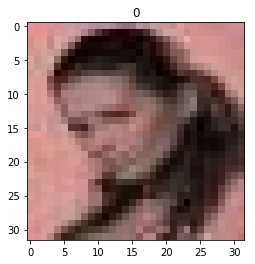

In [10]:
inputs, classes = train_dataset[0]
out = torchvision.utils.make_grid(inputs)
imshow(out, title=idx_to_class[classes])

In [19]:
# refactor from recitation 6 and https://github.com/hysts/pytorch_resnet/blob/master/resnet.py

class BottleneckBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.expansion = 4
        bottleneck_channels = out_channels // self.expansion
        self.in_channels, self.out_channels = in_channels, out_channels
        self.conv1 = nn.Conv2d(in_channels,bottleneck_channels,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)
        self.conv2 = nn.Conv2d(bottleneck_channels,bottleneck_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        self.conv3 = nn.Conv2d(bottleneck_channels,out_channels,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,padding=0,bias=False),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)), inplace=True)
        y = F.relu(self.bn2(self.conv2(y)), inplace=True)
        y = self.bn3(self.conv3(y))
        y += self.shortcut(x)
        y = F.relu(y, inplace=True)
        return y

In [20]:
# refactor from recitation 6 and https://github.com/hysts/pytorch_resnet/blob/master/resnet.py

class Network(nn.Module):
    def __init__(self, num_feats, num_classes):
        super(Network, self).__init__()

        self.layers = []

        self.layers.append(nn.Conv2d(in_channels=num_feats, out_channels=64, kernel_size=5, padding = 2, stride=1, bias=False))
        self.layers.append(nn.BatchNorm2d(64))
        self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.MaxPool2d(3, stride=2, padding=1))

        in_channels = 64
        for out_channels, block_count in zip([128,256,512,1024],[2,3,5,3]):
            for i in range(block_count):
                self.layers.append(BottleneckBlock(in_channels, out_channels))
                in_channels = out_channels

        self.layers.append(nn.AdaptiveAvgPool2d((1,1)))
        self.layers.append(nn.Flatten())
        self.layers.append(nn.BatchNorm1d(1024))
        self.layers.append(nn.ReLU(inplace=True))

        self.layers = nn.Sequential(*self.layers)
        self.linear_label = nn.Linear(1024, num_classes, bias=False)
    
    def forward(self, x):
        features = self.layers(x)
          
        label_output = self.linear_label(features)
        #label_output = label_output/torch.norm(self.linear_label.weight, dim=1)
        
        return features, label_output
    
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif type(m) == nn.BatchNorm2d:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [25]:
model = Network(3, len(train_dataset.classes))
model.apply(init_weights)
model.cuda()
print (model)

Network(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): BottleneckBlock(
      (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNo

In [26]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4, nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
criterion = nn.CrossEntropyLoss()

In [29]:
def train(model, data_loader, test_loader, task='Classification'):
    best_model = None
    lowest_val_acc = None
    model.train()

    for epoch in range(10):
        avg_loss = 0.0
        for batch_num, (feats, labels) in tqdm(enumerate(data_loader)):
            feats, labels = feats.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(feats)[1]

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()

            if batch_num % 100 == 99:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/100))
                avg_loss = 0.0    
            
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        scheduler.step()
        
            
        val_loss, val_acc = test_classify(model, test_loader)
        #train_loss, train_acc = test_classify(model, data_loader)
        print('Val Loss: {:.4f}\tVal Accuracy: {:.4f}'.format(val_loss, val_acc))
        torch.save(model.state_dict(), MODEL_PATH+'Checkpoint/model_%d_%d.pt'%(int(time.time()), epoch+1))
        if ((best_model == None) or (val_acc < lowest_acc)):
            best_model = model
            lowest_acc = val_acc
            
    torch.save(best_model.state_dict(), MODEL_PATH+'model_%d.pt'%int(time.time()))
    return best_model
           

def test_classify(model, test_loader):
    model.eval()
    test_loss = []
    accuracy = 0
    total = 0
    with torch.no_grad():
        for batch_num, (feats, labels) in tqdm(enumerate(test_loader)):
            feats, labels = feats.cuda(), labels.cuda()
            outputs = model(feats)[1]

            _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
            pred_labels = pred_labels.view(-1)

            loss = criterion(outputs, labels.long())

            accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
            total += len(labels)
            test_loss.extend([loss.item()]*feats.size()[0])
            del feats
            del labels
    model.train()
    return np.mean(test_loss), accuracy/total


In [30]:
best_model = train(model, train_dataloader, dev_dataloader)

Epoch: 1	Batch: 100	Avg-Loss: 6.4390
Epoch: 1	Batch: 200	Avg-Loss: 6.2597
Epoch: 1	Batch: 300	Avg-Loss: 6.0549
Epoch: 1	Batch: 400	Avg-Loss: 5.8940
Epoch: 1	Batch: 500	Avg-Loss: 5.7199
Epoch: 1	Batch: 600	Avg-Loss: 5.5639
Epoch: 1	Batch: 700	Avg-Loss: 5.4209
Epoch: 1	Batch: 800	Avg-Loss: 5.2822
Epoch: 1	Batch: 900	Avg-Loss: 5.1538
Epoch: 1	Batch: 1000	Avg-Loss: 5.0429
Epoch: 1	Batch: 1100	Avg-Loss: 4.9057
Epoch: 1	Batch: 1200	Avg-Loss: 4.8180
Epoch: 1	Batch: 1300	Avg-Loss: 4.6932
Epoch: 1	Batch: 1400	Avg-Loss: 4.6001
Epoch: 1	Batch: 1500	Avg-Loss: 4.4641
Epoch: 1	Batch: 1600	Avg-Loss: 4.3939
Epoch: 1	Batch: 1700	Avg-Loss: 4.2794
Epoch: 1	Batch: 1800	Avg-Loss: 4.2213
Epoch: 1	Batch: 1900	Avg-Loss: 4.1259
Epoch: 1	Batch: 2000	Avg-Loss: 4.0456
Epoch: 1	Batch: 2100	Avg-Loss: 3.9828
Epoch: 1	Batch: 2200	Avg-Loss: 3.9188
Epoch: 1	Batch: 2300	Avg-Loss: 3.8377
Epoch: 1	Batch: 2400	Avg-Loss: 3.7650
Epoch: 1	Batch: 2500	Avg-Loss: 3.7088
Epoch: 1	Batch: 2600	Avg-Loss: 3.6550
Epoch: 1	Batch: 2700	


Val Loss: 3.8344	Val Accuracy: 0.2683


Epoch: 2	Batch: 100	Avg-Loss: 3.1172
Epoch: 2	Batch: 200	Avg-Loss: 3.0747
Epoch: 2	Batch: 300	Avg-Loss: 3.0480
Epoch: 2	Batch: 400	Avg-Loss: 3.0126
Epoch: 2	Batch: 500	Avg-Loss: 3.0062
Epoch: 2	Batch: 600	Avg-Loss: 2.9722
Epoch: 2	Batch: 700	Avg-Loss: 2.9262
Epoch: 2	Batch: 800	Avg-Loss: 2.8894
Epoch: 2	Batch: 900	Avg-Loss: 2.8901
Epoch: 2	Batch: 1000	Avg-Loss: 2.8407
Epoch: 2	Batch: 1100	Avg-Loss: 2.8103
Epoch: 2	Batch: 1200	Avg-Loss: 2.8280
Epoch: 2	Batch: 1300	Avg-Loss: 2.7845
Epoch: 2	Batch: 1400	Avg-Loss: 2.7441
Epoch: 2	Batch: 1500	Avg-Loss: 2.7204
Epoch: 2	Batch: 1600	Avg-Loss: 2.7060
Epoch: 2	Batch: 1700	Avg-Loss: 2.6859
Epoch: 2	Batch: 1800	Avg-Loss: 2.6377
Epoch: 2	Batch: 1900	Avg-Loss: 2.6233
Epoch: 2	Batch: 2000	Avg-Loss: 2.6143
Epoch: 2	Batch: 2100	Avg-Loss: 2.6030
Epoch: 2	Batch: 2200	Avg-Loss: 2.5763
Epoch: 2	Batch: 2300	Avg-Loss: 2.5616
Epoch: 2	Batch: 2400	Avg-Loss: 2.5603
Epoch: 2	Batch: 2500	Avg-Loss: 2.5440
Epoch: 2	Batch: 2600	Avg-Loss: 2.5242
Epoch: 2	Batch: 2700	


Val Loss: 2.8419	Val Accuracy: 0.4228


Epoch: 3	Batch: 100	Avg-Loss: 2.1897
Epoch: 3	Batch: 200	Avg-Loss: 2.1663
Epoch: 3	Batch: 300	Avg-Loss: 2.1670
Epoch: 3	Batch: 400	Avg-Loss: 2.1768
Epoch: 3	Batch: 500	Avg-Loss: 2.1721
Epoch: 3	Batch: 600	Avg-Loss: 2.1695
Epoch: 3	Batch: 700	Avg-Loss: 2.1692
Epoch: 3	Batch: 800	Avg-Loss: 2.1743
Epoch: 3	Batch: 900	Avg-Loss: 2.1303
Epoch: 3	Batch: 1000	Avg-Loss: 2.1651
Epoch: 3	Batch: 1100	Avg-Loss: 2.1359
Epoch: 3	Batch: 1200	Avg-Loss: 2.1396
Epoch: 3	Batch: 1300	Avg-Loss: 2.1102
Epoch: 3	Batch: 1400	Avg-Loss: 2.1083
Epoch: 3	Batch: 1500	Avg-Loss: 2.1180
Epoch: 3	Batch: 1600	Avg-Loss: 2.1194
Epoch: 3	Batch: 1700	Avg-Loss: 2.1364
Epoch: 3	Batch: 1800	Avg-Loss: 2.1055
Epoch: 3	Batch: 1900	Avg-Loss: 2.1029
Epoch: 3	Batch: 2000	Avg-Loss: 2.1080
Epoch: 3	Batch: 2100	Avg-Loss: 2.1127
Epoch: 3	Batch: 2200	Avg-Loss: 2.0993
Epoch: 3	Batch: 2300	Avg-Loss: 2.0682
Epoch: 3	Batch: 2400	Avg-Loss: 2.0652
Epoch: 3	Batch: 2500	Avg-Loss: 2.0872
Epoch: 3	Batch: 2600	Avg-Loss: 2.0474
Epoch: 3	Batch: 2700	


Val Loss: 2.4132	Val Accuracy: 0.5074


Epoch: 4	Batch: 100	Avg-Loss: 1.7934
Epoch: 4	Batch: 200	Avg-Loss: 1.7779
Epoch: 4	Batch: 300	Avg-Loss: 1.8064
Epoch: 4	Batch: 400	Avg-Loss: 1.7844
Epoch: 4	Batch: 500	Avg-Loss: 1.8085
Epoch: 4	Batch: 600	Avg-Loss: 1.8043
Epoch: 4	Batch: 700	Avg-Loss: 1.8110
Epoch: 4	Batch: 800	Avg-Loss: 1.8054
Epoch: 4	Batch: 900	Avg-Loss: 1.7978
Epoch: 4	Batch: 1000	Avg-Loss: 1.7985
Epoch: 4	Batch: 1100	Avg-Loss: 1.8387
Epoch: 4	Batch: 1200	Avg-Loss: 1.8357
Epoch: 4	Batch: 1300	Avg-Loss: 1.8516
Epoch: 4	Batch: 1400	Avg-Loss: 1.8203
Epoch: 4	Batch: 1500	Avg-Loss: 1.7898
Epoch: 4	Batch: 1600	Avg-Loss: 1.8368
Epoch: 4	Batch: 1700	Avg-Loss: 1.8222
Epoch: 4	Batch: 1800	Avg-Loss: 1.8213
Epoch: 4	Batch: 1900	Avg-Loss: 1.8085
Epoch: 4	Batch: 2000	Avg-Loss: 1.8282
Epoch: 4	Batch: 2100	Avg-Loss: 1.8139
Epoch: 4	Batch: 2200	Avg-Loss: 1.8084
Epoch: 4	Batch: 2300	Avg-Loss: 1.8328
Epoch: 4	Batch: 2400	Avg-Loss: 1.8138
Epoch: 4	Batch: 2500	Avg-Loss: 1.7993
Epoch: 4	Batch: 2600	Avg-Loss: 1.8258
Epoch: 4	Batch: 2700	


Val Loss: 2.3241	Val Accuracy: 0.5237


Epoch: 5	Batch: 100	Avg-Loss: 1.5727
Epoch: 5	Batch: 200	Avg-Loss: 1.5555
Epoch: 5	Batch: 300	Avg-Loss: 1.5665
Epoch: 5	Batch: 400	Avg-Loss: 1.5918
Epoch: 5	Batch: 500	Avg-Loss: 1.6077
Epoch: 5	Batch: 600	Avg-Loss: 1.5979
Epoch: 5	Batch: 700	Avg-Loss: 1.5926
Epoch: 5	Batch: 800	Avg-Loss: 1.6021
Epoch: 5	Batch: 900	Avg-Loss: 1.6206
Epoch: 5	Batch: 1000	Avg-Loss: 1.6000
Epoch: 5	Batch: 1100	Avg-Loss: 1.6040
Epoch: 5	Batch: 1200	Avg-Loss: 1.6203
Epoch: 5	Batch: 1300	Avg-Loss: 1.6566
Epoch: 5	Batch: 1400	Avg-Loss: 1.6229
Epoch: 5	Batch: 1500	Avg-Loss: 1.6433


KeyboardInterrupt: 

In [31]:
#best_model = model
best_model = Network(3, len(train_dataset.classes))
best_model.load_state_dict(torch.load(MODEL_PATH+'Checkpoint/model_1583538327_4.pt'))
best_model.cuda()
val_loss, val_acc = test_classify(best_model, dev_dataloader)
print('Val Loss: {:.4f}\tVal Accuracy: {:.4f}'.format(val_loss, val_acc))


Val Loss: 2.3366	Val Accuracy: 0.5133


In [37]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4, nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [38]:
def fine_train(model, data_loader, test_loader, task='Classification'):
    best_model = None
    lowest_val_acc = None
    model.train()

    for epoch in range(5):
        avg_loss = 0.0
        for batch_num, (feats, labels) in tqdm(enumerate(data_loader)):
            feats, labels = feats.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(feats)[1]

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()

            if batch_num % 100 == 99:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/100))
                avg_loss = 0.0    
            
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
            
        fine_scheduler.step()
        val_loss, val_acc = test_classify(model, test_loader)
        print('Val Loss: {:.4f}\tVal Accuracy: {:.4f}'.
                format(val_loss, val_acc))
        torch.save(model.state_dict(), MODEL_PATH+'Checkpoint/model_%d_%d.pt'%(int(time.time()), epoch+1))
        if ((best_model == None) or (val_acc < lowest_acc)):
            best_model = model
            lowest_acc = val_acc
    torch.save(best_model.state_dict(), MODEL_PATH+'model_%d.pt'%int(time.time()))
    return best_model


In [ ]:
best_model = fine_train(best_model, train_dataloader, dev_dataloader)

In [ ]:
class TestImageFolder(Dataset):

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.jpg'):
                    self.file_list.append(file)
        self.file_list.sort()
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,
                                self.file_list[idx])
        to_pil = torchvision.transforms.Compose([torchvision.transforms.ToPILImage()])
        image = to_pil(plt.imread(img_name))
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
test_dataset = TestImageFolder(DATA_PATH+'test_classification/medium', 
                                               transform=data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, 
                                             shuffle=False, num_workers=num_workers,pin_memory=True)

In [ ]:
len(test_dataset)

In [ ]:
print (test_dataset.file_list[0])
print (test_dataset[0][1].shape)

In [ ]:
inputs = test_dataset[0]
out = torchvision.utils.make_grid(inputs)
imshow(out,title=test_dataset.file_list[0])

In [ ]:
model = Network(3, len(train_dataset.classes))
model.load_state_dict(torch.load(MODEL_PATH+'model_1583478712.pt'))
model.cuda()

model.eval()

image_names = test_dataset.file_list
test_preds = torch.LongTensor().cuda()
with torch.no_grad():
    for batch_num, feats in tqdm(enumerate(test_dataloader)):
        feats = feats.cuda()
        outputs = model(feats)[1]

        _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
        pred_labels = pred_labels.view(-1)
        test_preds = torch.cat((test_preds, pred_labels), dim=0)

        del feats
        del pred_labels
    
out_df = pd.DataFrame()
out_df['Id'] = image_names
out_df['Category'] = test_preds.cpu().numpy()
out_df['Category'] = out_df['Category'].map(idx_to_class)
out_df.head()

In [ ]:
file_name = SUBMISSION_PATH+"submission_%d.csv"%int(time.time())
out_df.to_csv(file_name,index=False)

In [ ]:
model1 = Network(3, len(train_dataset.classes),4096)
model1.load_state_dict(torch.load(MODEL_PATH+'model_1583111170.pt'))